In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


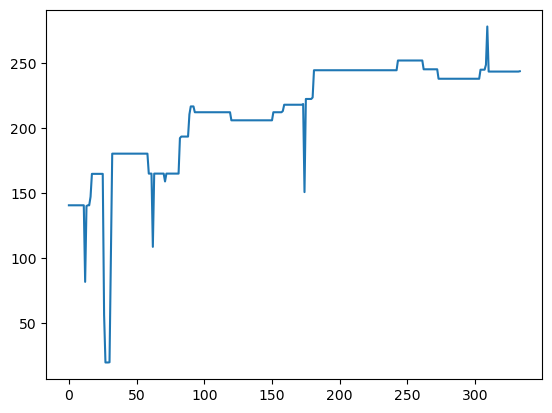

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
 
df = pd.read_csv('project_b.csv')
timeseries = df[["cost"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

In [24]:
timeseries

array([[140.64516 ],
       [140.64516 ],
       [140.64516 ],
       [140.64516 ],
       [140.64516 ],
       [140.64516 ],
       [140.64516 ],
       [140.64516 ],
       [140.64516 ],
       [140.64516 ],
       [140.64516 ],
       [140.64516 ],
       [ 81.886856],
       [140.08801 ],
       [140.64516 ],
       [140.64516 ],
       [147.18373 ],
       [164.77419 ],
       [164.77419 ],
       [164.77419 ],
       [164.77419 ],
       [164.77419 ],
       [164.77419 ],
       [164.77419 ],
       [164.77419 ],
       [164.77419 ],
       [ 56.521687],
       [ 20.      ],
       [ 20.      ],
       [ 20.      ],
       [ 20.16278 ],
       [100.03574 ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2857  ],
       [180.2

In [25]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [26]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=12, num_layers=1, batch_first=True)
        self.linear = nn.Linear(12, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [27]:
lookback = 12

In [28]:
# train-test split for time series
train_size = int(len(timeseries[:304-lookback-15]))
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
print(train_size, test_size)

277 57


In [29]:
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [30]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 3000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 210.6493, test RMSE 241.6727
Epoch 100: train RMSE 166.1701, test RMSE 196.0677
Epoch 200: train RMSE 127.8666, test RMSE 156.2966
Epoch 300: train RMSE 91.8740, test RMSE 117.9740
Epoch 400: train RMSE 60.5243, test RMSE 82.1577
Epoch 500: train RMSE 37.0400, test RMSE 50.9832
Epoch 600: train RMSE 22.6504, test RMSE 27.4139
Epoch 700: train RMSE 17.2519, test RMSE 16.5227
Epoch 800: train RMSE 15.5005, test RMSE 13.9567
Epoch 900: train RMSE 14.5098, test RMSE 12.2168
Epoch 1000: train RMSE 13.5728, test RMSE 11.2121
Epoch 1100: train RMSE 12.7899, test RMSE 10.0808
Epoch 1200: train RMSE 12.2688, test RMSE 9.1991
Epoch 1300: train RMSE 11.7871, test RMSE 8.3356
Epoch 1400: train RMSE 11.4874, test RMSE 7.3382
Epoch 1500: train RMSE 11.3155, test RMSE 6.7107
Epoch 1600: train RMSE 11.3102, test RMSE 6.1636
Epoch 1700: train RMSE 11.0243, test RMSE 6.5163
Epoch 1800: train RMSE 11.1553, test RMSE 6.2999
Epoch 1900: train RMSE 10.8114, test RMSE 6.1333
Epoch 2000: t

In [31]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

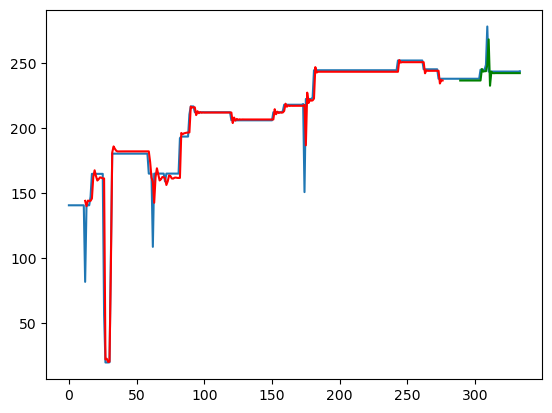

In [32]:
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

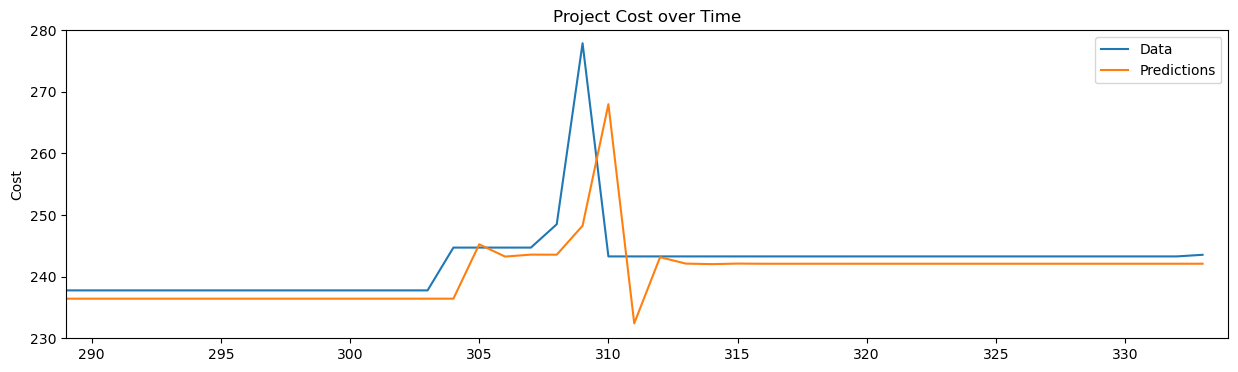

In [33]:
# plot
plt.figure(figsize=(15,4))
plt.plot(timeseries)
plt.plot(test_plot)
plt.legend(('Data', 'Predictions'))
plt.title('Project Cost over Time')
plt.ylabel('Cost')
plt.xlim(train_size + lookback, len(timeseries))
plt.ylim(230, 280)
plt.show()